In [ ]:
!pip install -qU kagglehub datasets torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# MLNI

Multi-genre natural language inference(MNLI): MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제입니다. 감정 분석과 같은 sentence classification이지만 문장이 두 개 주어집니다. 이 링크의 data를 활용하시면 됩니다. Test data는 validation_matched.csv를 활용하시면 됩니다.

    

## 1. Load Dataset

- 데이터셋에서 premise(전제) / hypothesis(가설) / label 이렇게 3가지만 필요하여 다른 칼럼은 모두 drop 하겠습니다.

- label

    1) 0: entailment
    2) 1: neutral
    3) 2: contradiction

- validation

    1) Matched Validation:

    정의: 훈련 세트와 동일한 장르에서 추출된 문장 쌍으로 구성된 검증 세트입니다.
    목적: 모델이 훈련된 도메인 내에서 얼마나 잘 일반화하는지 평가합니다.
    구분분: fiction	government	slate	telephone	travel
    
    2) Mismatched Validation:

    정의: 훈련 세트에 없는 다른 장르에서 추출된 문장 쌍으로 구성된 검증 세트입니다.
    목적: 모델이 새로운 도메인이나 장르에 대해 얼마나 잘 일반화하는지 평가합니다.
    구분: facetoface	letters	nineeleven	oup	verbatim

    

In [ ]:
import kagglehub
import pandas as pd
from pathlib import Path
from IPython.display import display

# 데이터 다운로드
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

# 데이터 경로로
# dir_path = Path("/home/paradeigma/.cache/kagglehub/datasets/thedevastator/unlocking-language-understanding-with-the-multin/versions/2")
dir_path = Path(path)
train_path = dir_path / "train.csv"
validation_matched = dir_path / "validation_matched.csv"
validatoin_mismatched = dir_path / "validation_mismatched.csv"

# 사용하려는 칼럼만으로 data load
col_lst = ['premise','hypothesis','label','genre']
data_lst = ['train_df', 'matched_val_df', 'mismatched_val_df']
train_df = pd.read_csv(train_path)[col_lst]

matched_val_df = pd.read_csv(validation_matched)[col_lst]

mismatched_val_df = pd.read_csv(validatoin_mismatched)[col_lst]


display(train_df.head(2))

100%|██████████| 109M/109M [00:01<00:00, 87.2MB/s] 

Extracting files...


,premise,hypothesis,label,genre
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,government
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,telephone


### 1.1 결측치 확인 및 제거

- train_df의 hypothesis에 40개의 결측치가 있음이 확인되었습니다.

- 그 외에 결측치가 확인되지 않아 train_df의 결측치만 모두 제거하였습니다.

In [ ]:
import numpy as np
result = np.array([df.isna().sum().values for df in [train_df, matched_val_df, mismatched_val_df]])
result = pd.DataFrame(result)
result.index = data_lst
result.columns = col_lst
display(result)

,premise,hypothesis,label,genre
train_df,0,40,0,0
matched_val_df,0,0,0,0
mismatched_val_df,0,0,0,0


In [ ]:
# hypothesis가 결측된 데이터를 확인해보았습니다.
# 별다른 특징은 보이지 않으 제거하였습니다.
display(train_df[train_df['hypothesis'].isna()].head())

,premise,hypothesis,label,genre
118,"Native 'Me win, me passum heap big law ...",NaN,2,slate
3318,Saint-Germain-des-Pr??s,NaN,1,travel
10612,weatherwise or otherwise weatherwise,NaN,0,telephone
19990,AICPA American Institute of Certified Public A...,NaN,2,government
34685,Tony Shoes (so Clinton will have Shoes and So...,NaN,0,slate


In [ ]:
train_df = train_df.dropna(how='any').reset_index(drop=True)

### 1.2 [My Code] EDA

- 라벨에 따른 premise, hypothesis 육안 확인

- 라벨 분포도 확인

- 장르 분포도 확인

- premise, hypothesis 길이 분포도 확인
    1) 길이에 따른 metric 비교를 위해 다음 3개로 데이터셋을 build할 예정입니다.
    
    - premise의 중앙값 + hypothesis의 중앙값 = 200

    - (premise의 중앙값 + 1 표준편차) + (hypothesis의 중앙값 + 1 표준편차) = 300

    - (premise의 중앙값 + 2 표준편차) + (hypothesis의 중앙값 + 2 표준편차) = 400



In [ ]:
from itertools import product
# 라벨에 따른 premise hypothesis 확인
def show_data(df, label, sample_num=2):
    display(df[df['label'] == label][['premise','hypothesis']].sample(sample_num))

for df, label in product([train_df, matched_val_df, mismatched_val_df],[0,1,2]):
    print(f"{label} 라벨")
    show_data(df, label)


0 라벨


,premise,hypothesis
217316,Many teen-agers are not moved by the possibili...,The idea of dying young doesn't seem to bother...
335410,"The Internet, computers, communications satell...",The internet is a fairly recent invention.


1 라벨


,premise,hypothesis
46594,He's 'bout th' most peaceful hombre I ever rod...,He's so peaceful because he took a vow of sile...
197996,The overly respectful way the United States an...,The tribal warlords felt insulted at how the U...


2 라벨


,premise,hypothesis
305741,"In Invisible Man , the Talented Tenth narrator...",The Talented Tenth narrator does not have to o...
258967,The spit-and-polish crowd campaigns for school...,The spit-and-polish crowd campaigns for no sch...


0 라벨


,premise,hypothesis
3155,i voted in the last national one yeah i'm not ...,I'm not sure if I got to vote in the last loca...
4723,yeah the the i mean people like that are crazy...,It was something I performed research on durin...


1 라벨


,premise,hypothesis
1644,36 million could mean the state's legal servic...,LSC will get a big increase in funding soon.
4386,This is arguably starting to distort the pract...,Scientific practice was changed by this method.


2 라벨


,premise,hypothesis
3035,I hate pigeons.,Pigeons are cute and adorable.
384,One opportunist who stayed was Octavius Decatu...,Octavius Decatur Gass refers to four people.


0 라벨


,premise,hypothesis
1066,"Then, too, there have been the campaigners who...",The gender of the person in question will dete...
7731,.. I chucked him out the door and he's not bee...,He is not in since I threw him out the door.


1 라벨


,premise,hypothesis
3643,"Communication tools like Safety-Wise, Happenin...","Volunteers are able to provide quality, inform..."
4392,These are challenging times for public institu...,No one cares about public education anymore so...


2 라벨


,premise,hypothesis
5961,We all realize how the availability or lack of...,We never socialized or asked for help from our...
2373,"If you have any questions, please feel free to...",Do not contact us if you have a question


In [ ]:
# 라벨 분포도 확인
# 라벨 분포도는 train_df, matched_val_df, mismatched_val_df 모두 고르게 분포되어 있음을 알 수 있습니다.
# 클래스 수는 3개이므로 3개 다중 분류 모델링을 해야 합니다.
result = [df['label'].value_counts(normalize=True).sort_index() for df in [train_df, matched_val_df, mismatched_val_df]]
result_df = pd.DataFrame(result).reset_index(drop=True)
result_df.index = ["train_df","matched_val_df",'mismatched_val_df']
display(result_df)

label,0,1,2
train_df,0.333330,0.333332,0.333338
matched_val_df,0.354457,0.318186,0.327356
mismatched_val_df,0.352217,0.318247,0.329536


In [ ]:
# genre 분포도 확인
# genre의 수는 5개로로 나뉘며 고르게 분포되어 있음을 알 수 있습니다.
# 그러면서 mismatched_df만 genre 분포가 아예 다르다는 것을 알 수 있습니다.
result = [df['genre'].value_counts(normalize=True).sort_index() for df in [train_df, matched_val_df]]
result_df = pd.DataFrame(result).reset_index(drop=True)
result_df.index = ["train_df","matched_val_df"]
display(result_df)

result = [df['genre'].value_counts(normalize=True).sort_index() for df in [mismatched_val_df]]
result_df = pd.DataFrame(result).reset_index(drop=True)
result_df.index = ["mismatched_val_df"]
display(result_df)

genre,fiction,government,slate,telephone,travel
train_df,0.196976,0.196958,0.196844,0.212249,0.196973
matched_val_df,0.201019,0.198166,0.199185,0.200306,0.201325


genre,facetoface,letters,nineeleven,oup,verbatim
mismatched_val_df,0.200773,0.201078,0.200773,0.199451,0.197925


#### [My Code] 텍스트 길이 분포 계산

- 통계량

    1) 평균: premise 대체로 120 / hypothesis 대체로 60

    2) 표준편차: premise 대체로 80 / hypothesis 대체로 25

    3) 왜도
    : 대체로 1~2 정도 나오는 것을 알 수 있습니다. 왜도가 0일 때 정규분포를 그리게 되며 양수일 때 right-skewed, 음수일 때 left-skewed 데이터를 형성합니다. 즉 해당 length 분포는 전체적으로 오른쪽으로 치우쳐있으며 극단적으로 긴 데이터가 존재한다는 것을 알 수 있습니다.

    4) 첨도:
    : premise는 10 이상이지만 hypothesis는 5미만입니다. 즉 봉우리가 premise 쪽에서 훨씬 뾰족하게 나와있어 다른 데이터가 평균으로부터 멀리 분포해 있음을 알 수 있습니다.

- max_len에 따른 metric 변화를 비교해보기 위하여 max_len이 200, 300, 400 일 때 각각에 대하여 데이터셋을 build하겠습니다.

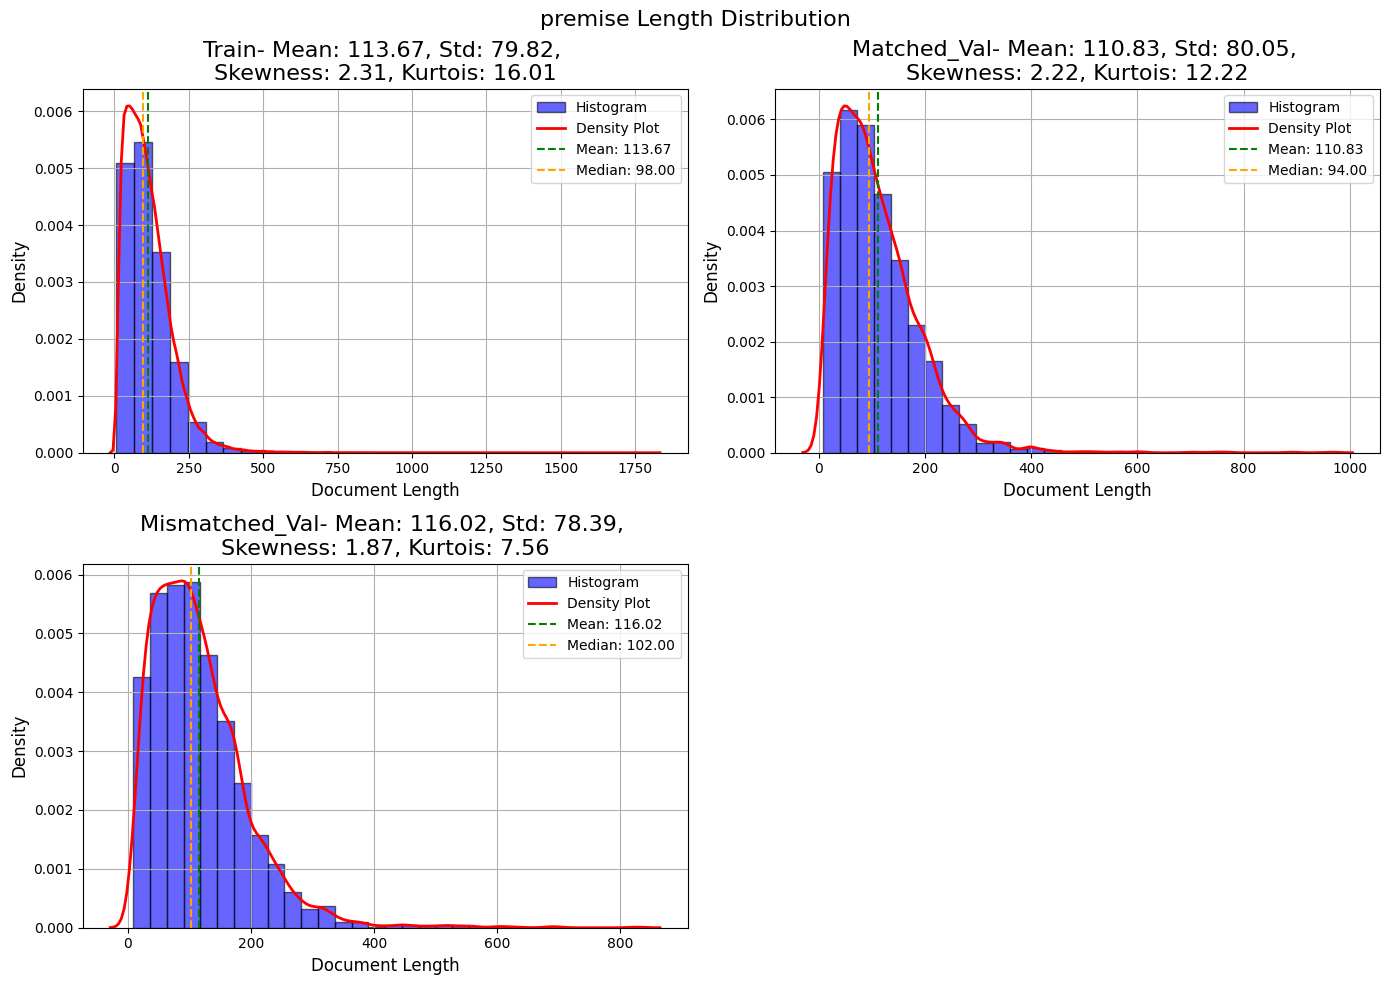

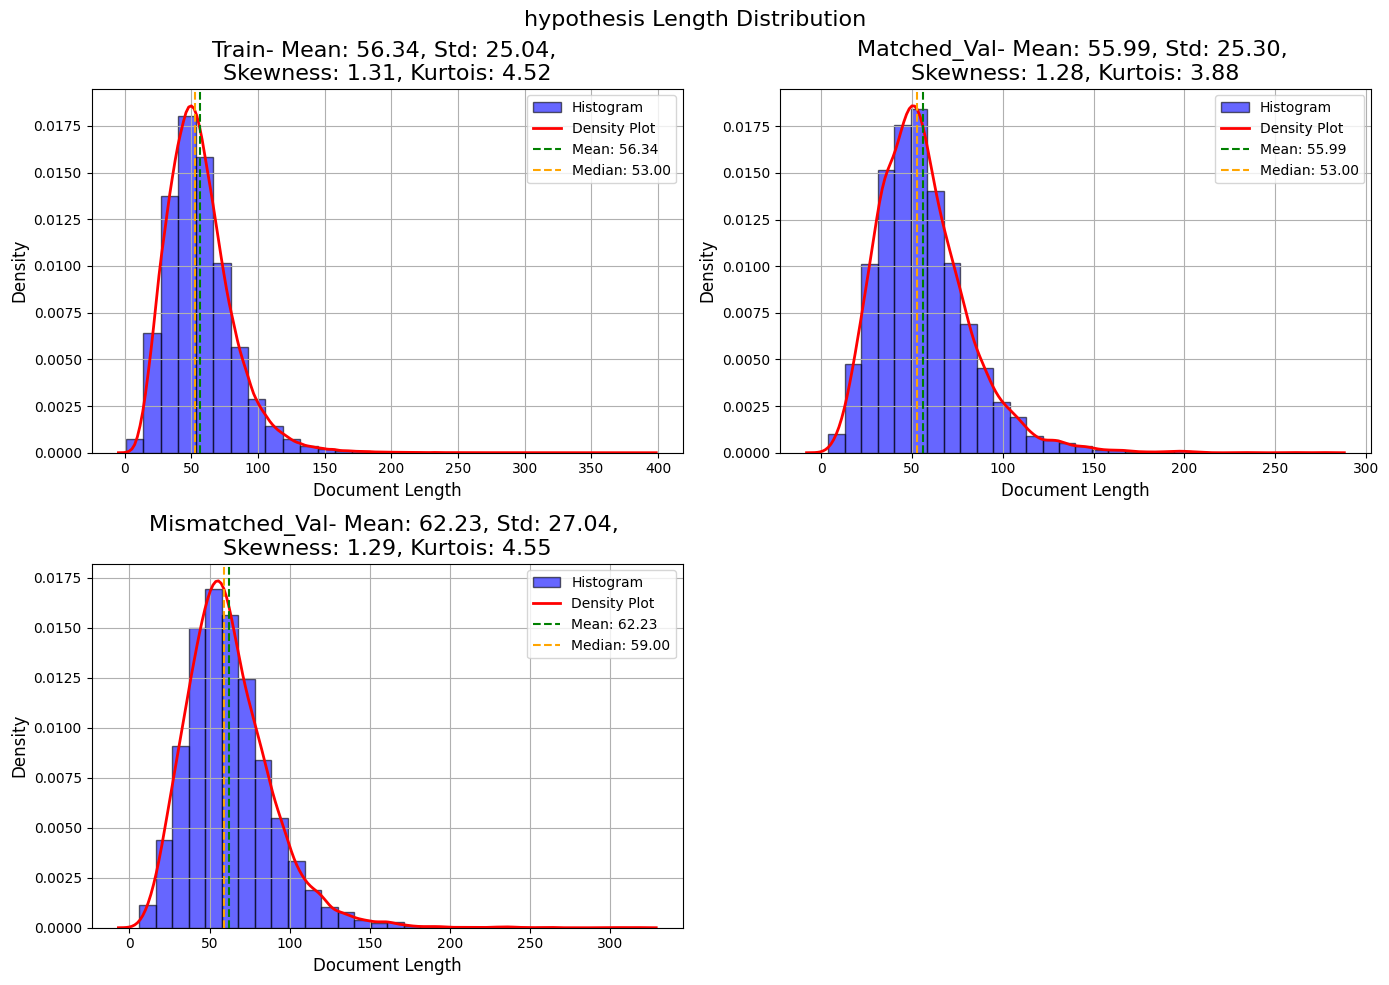

In [ ]:
# premise, hypothesis 길이 분포
# 평균, 표준편차, 왜도, 첨도 계산산
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis

def length_plot(data, name):
    plt.hist(data, bins=30, alpha=0.6, label=f'Histogram', color='blue', edgecolor='black', density=True)
    sns.kdeplot(data, label=f'Density Plot', color='red', linewidth=2)

    mean_value = np.mean(data)
    mean_value = np.mean(data)
    std_dev = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    median_value = np.median(data)

    plt.axvline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
    plt.title(f'{name}- Mean: {mean_value:.2f}, Std: {std_dev:.2f}, \nSkewness: {skewness:.2f}, Kurtois: {kurt:.2f}', fontsize=16)
    plt.xlabel('Document Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)

def final_length_plot(length_type):
    plt.figure(figsize=(14,10))

    for i, (df, name) in enumerate(zip([train_df, matched_val_df, mismatched_val_df],['Train', 'Matched_Val', 'Mismatched_Val'])):
        plt.subplot(2,2,i+1)
        length_plot([len(row[length_type]) for _, row in df.iterrows()], name)

    plt.suptitle(f"{length_type} Length Distribution", fontsize=16)
    plt.tight_layout()
    print("\n\n")

final_length_plot('premise')
final_length_plot('hypothesis')
plt.show()


In [ ]:
# 모델 config입니다.
model_name = "bert-base-uncased"

test_size = 0.2
random_state = 42
batch_size = 64
max_len_dict = {'max_len_1' : 200, 'max_len_2': 300, 'max_len_3': 400}

results_dir = './results/week3_advanced'
lr = 0.001
n_epochs = 10

### 1.2 [My Code] Preprocess Data

- tokenizer: bert base tokenizer를 사용합니다.

- 데이터셋 구성

    1) train: train_df의 80% / 314129

    2) val: train_df의 20% / 78533

    3) test: matched_val과 mismatched_val_df를 모두 사용합니다 / 9815 - 9832

    : matched_val은 같은 장르 내의 데이터가 학습된 것이기에 mismatched_val_df보다 더 좋은 metric을 보일 것이라 예상합니다.

    : mismatched_val_df는 zeroshot validation이라 할 수 있기에 metric이 더 안나올 것이라 예상할 수 있습니다.

- tokenize 함수를 이용해 max_len이 200, 300, 400인 데이터셋 3개를 만들었습니다.

In [ ]:
from transformers import BertTokenizer

# bert tokenizer를 사용합니다.
# 데이터셋은 imdb 영화 리뷰 데이터입니다.
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# train, val, test로 데이터 나누기
from sklearn.model_selection import train_test_split

train_df = train_df[['premise','hypothesis','label']]
test_df = matched_val_df[['premise','hypothesis','label']]
zeroshot_test_df = mismatched_val_df[['premise','hypothesis','label']]

train_df, val_df = train_test_split(train_df, test_size=test_size)

In [ ]:
x_train = train_df[['premise','hypothesis']]
y_train = train_df['label']

x_val = val_df[['premise','hypothesis']]
y_val = val_df['label']

x_test = test_df[['premise','hypothesis']]
y_test = test_df['label']

x_test_zeroshot = zeroshot_test_df[['premise','hypothesis']]
y_test_zeroshot = zeroshot_test_df['label']

num = 0

print(f"x_train len: {len(x_train)}")
print(f"y_train len: {len(y_train)}")
print(f"sample train = label : {y_train.iloc[num]}\n text:{x_train.iloc[num]}\n")

print(f"x_val len: {len(x_val)}")
print(f"y_val len: {len(y_val)}")
print(f"sample val= label : {y_val.iloc[num]}\n text:{x_val.iloc[num]}\n")

print(f"x_test shape: {len(x_test)}")
print(f"y_test len: {len(y_test)}\n")
print(f"sample test = label : {y_test.iloc[num]}\n text:{x_test.iloc[num]}\n")

print(f"x_test_zeroshot shape: {len(x_test_zeroshot)}")
print(f"y_test_zeroshot len: {len(y_test_zeroshot)}\n")
print(f"sample test zeroshot = label : {y_test_zeroshot.iloc[num]}\n text:{x_test_zeroshot.iloc[num]}\n")

x_train len: 314129
y_train len: 314129
sample train = label : 1
 text:premise                David Duke is back.
hypothesis    I'm glad David Duke is back.
Name: 357228, dtype: object

x_val len: 78533
y_val len: 78533
sample val= label : 1
 text:premise        It also has the only spiral minaret in the city.
hypothesis    It at one point was the only spiral minaret in...
Name: 382030, dtype: object

x_test shape: 9815
y_test len: 9815

sample test = label : 1
 text:premise                   The new rights are nice enough
hypothesis    Everyone really likes the newest benefits 
Name: 0, dtype: object

x_test_zeroshot shape: 9832
y_test_zeroshot len: 9832

sample test zeroshot = label : 2
 text:premise       Your contribution helped make it possible for ...
hypothesis    Your contributions were of no help with our st...
Name: 0, dtype: object



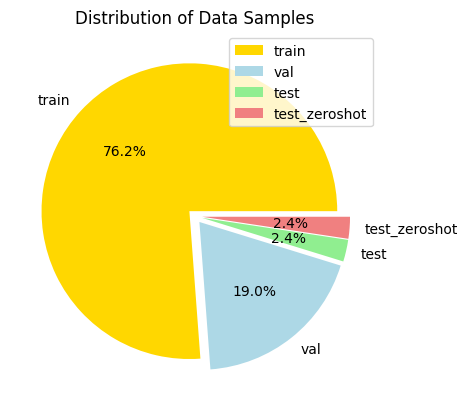

In [ ]:
import matplotlib.pyplot as plt

sizes = [len(x_train), len(x_val), len(x_test), len(x_test_zeroshot)]
labels = ['train', 'val', 'test', 'test_zeroshot']
colors = ['gold', 'lightblue', 'lightgreen', 'lightcoral']
explode = [0.05] * len(sizes)  # 각 조각을 0.1만큼 분리

plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%')
plt.title('Distribution of Data Samples')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# 허깅페이스 데이터셋 형태로 바꾸기
from datasets import Dataset, DatasetDict
from transformers import logging


def tokenize(batch, max_len):

  return tokenizer(
    batch["premise"],
    batch['hypothesis'],
    padding="max_length",
    max_length = max_len,
    truncation="longest_first" ,
    return_tensors = 'pt')


train_data = {
    'premise': x_train['premise'],
    'hypothesis': x_train['hypothesis'],
    "label": y_train,
}

val_data = {
    'premise': x_val['premise'],
    'hypothesis': x_val['hypothesis'],
    "label": y_val,
}

test_data = {
    'premise': x_test['premise'],
    'hypothesis': x_test['hypothesis'],
    "label": y_test,
}

test_data_zeroshot = {
    'premise': x_test_zeroshot['premise'],
    'hypothesis': x_test_zeroshot['hypothesis'],
    "label": y_test_zeroshot,
}

train_dataset = Dataset.from_dict(train_data)
train_dataset_1 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
train_dataset_2 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)
train_dataset_3 = train_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_3']), batched=True)

val_dataset = Dataset.from_dict(val_data)
val_dataset_1 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
val_dataset_2 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)
val_dataset_3 = val_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_3']), batched=True)

test_dataset = Dataset.from_dict(test_data)
test_dataset_1 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
test_dataset_2 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)
test_dataset_3 = test_dataset.map(lambda batch: tokenize(batch, max_len_dict['max_len_3']), batched=True)

test_dataset_zeroshot = Dataset.from_dict(test_data_zeroshot)
test_dataset_zeroshot_1 = test_dataset_zeroshot.map(lambda batch: tokenize(batch, max_len_dict['max_len_1']), batched=True)
test_dataset_zeroshot_2 = test_dataset_zeroshot.map(lambda batch: tokenize(batch, max_len_dict['max_len_2']), batched=True)
test_dataset_zeroshot_3 = test_dataset_zeroshot.map(lambda batch: tokenize(batch, max_len_dict['max_len_3']), batched=True)


dataset_dict_1 = DatasetDict(
    {
        "train": train_dataset_1,
        "val": val_dataset_1,
        "test": test_dataset_1,
        "test_data_zeroshot": test_dataset_zeroshot_1
    }
)

dataset_dict_2 = DatasetDict(
    {
        "train": train_dataset_2,
        "val": val_dataset_2,
        "test": test_dataset_2,
        "test_data_zeroshot": test_dataset_zeroshot_2
    }
)

dataset_dict_3 = DatasetDict(
    {
        "train": train_dataset_3,
        "val": val_dataset_3,
        "test": test_dataset_3,
        "test_data_zeroshot": test_dataset_zeroshot_3
    }
)


dataset_dict = DatasetDict(
    {
        "max_len_1" : dataset_dict_1,
        "max_len_2" : dataset_dict_2,
        "max_len_3" : dataset_dict_3,
    }
)

Map:   0%|          | 0/314129 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/314129 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/314129 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Map:   0%|          | 0/78533 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/78533 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/78533 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

## 2.[My Code] Model Load

: 허깅페이스의 trainer로 구현을 하는 것이 이번 과제의 추가 목표입니다.

- 모델을 로드합니다. 이 때, num_labels=3로 하면 클래스 3의 다중중 분류기 classifer를 달아줍니다.

- metrics: accuracy와 f1 score

- optimizer: Adamw

- batch_size = 64,

- lr = 1e-3

### 2.1 [My Code] Max len에 따른 모델

- 모델 2개를 dict에 묶고, key는 max_len_1, max_len_2, max_len_3으로 선언합니다

In [ ]:
from transformers import BertForSequenceClassification
from torchinfo import summary
import torch

def build_model(freeze=True):
    # 모델 로드
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4)

    # 분류기 이전의 모든 파라미터 동결
    if freeze:
        for param in model.bert.parameters():
            param.requires_grad = False
    return model

model_dict = {
    'max_len_1-freeze' : build_model(freeze=True),
    'max_len_2-freeze' : build_model(freeze=True),
    'max_len_3-freeze' : build_model(freeze=True),
}

# 모델 정보 출력
for max_len_type in model_dict.keys():
    print(f"Model Summary: {max_len_type}")
    print(summary(model_dict[max_len_type], input_size=(batch_size, max_len_dict[max_len_type.split('-')[0]]), dtypes=[torch.int64]))
    print("\n\n")



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Summary: max_len_1-freeze


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                                       Output Shape              Param #
BertForSequenceClassification                                [64, 4]                   --
├─BertModel: 1-1                                             [64, 768]                 --
│    └─BertEmbeddings: 2-1                                   [64, 200, 768]            --
│    │    └─Embedding: 3-1                                   [64, 200, 768]            (23,440,896)
│    │    └─Embedding: 3-2                                   [64, 200, 768]            (1,536)
│    │    └─Embedding: 3-3                                   [1, 200, 768]             (393,216)
│    │    └─LayerNorm: 3-4                                   [64, 200, 768]            (1,536)
│    │    └─Dropout: 3-5                                     [64, 200, 768]            --
│    └─BertEncoder: 2-2                                      [64, 200, 768]            --
│    │    └─ModuleList: 3-6                                  --     

## 3.[My Code] Training

- huggingface trainer를 사용하여 훈련을 진행합니다.

- 확실히 naive torch 버전으로 모델을 훈련시키는 것보다 코드가 간편해지는 것을 확인할 수 있습니다.

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import os
os.environ["WANDB_DISABLED"] = "true"
# compute metrics은 반드시 아래와 같이 dict의 형태로 나와야 한다.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}

training_args = TrainingArguments(
    output_dir=results_dir,
    num_train_epochs=n_epochs,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir=results_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none"
)

In [ ]:
def build_triner(max_len_type, training_args):
    trainer = Trainer(
        model=model_dict[max_len_type],
        args=training_args,
        train_dataset=dataset_dict[max_len_type.split('-')[0]]["train"],
        eval_dataset=dataset_dict[max_len_type.split('-')[0]]["val"],
        compute_metrics=compute_metrics,
    )

    return trainer

trainer_dict = {
    'max_len_1-freeze' : build_triner('max_len_1-freeze', training_args),
    'max_len_2-freeze' : build_triner('max_len_2-freeze', training_args),
    'max_len_3-freeze' : build_triner('max_len_2-freeze', training_args),
}

In [ ]:
trainer_dict['max_len_1-freeze'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.092500,1.077323,0.405702,0.353671
2,1.081500,1.074575,0.403818,0.338309
3,1.077800,1.071658,0.410019,0.365593
4,1.076200,1.075104,0.413762,0.347935
5,1.075000,1.069962,0.412846,0.370132
6,1.074400,1.070564,0.417901,0.403261
7,1.073700,1.070152,0.407421,0.350840
8,1.073000,1.069194,0.411776,0.357575
9,1.073000,1.069057,0.412655,0.356791
10,1.072700,1.068624,0.415596,0.370107


TrainOutput(global_step=49090, training_loss=1.076987132610384, metrics={'train_runtime': 10564.0155, 'train_samples_per_second': 297.358, 'train_steps_per_second': 4.647, 'total_flos': 3.22860534710064e+17, 'train_loss': 1.076987132610384, 'epoch': 10.0})

In [ ]:
trainer_dict['max_len_2-freeze'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.094100,1.077478,0.405104,0.365674
2,1.081900,1.074672,0.404658,0.344029
3,1.078000,1.072058,0.408389,0.371832
4,1.076300,1.075687,0.412451,0.346812
5,1.075100,1.070199,0.411954,0.371038
6,1.074400,1.070658,0.417722,0.401928
7,1.073900,1.070549,0.405868,0.350078
8,1.073600,1.069352,0.410974,0.358186
9,1.073100,1.069335,0.411534,0.355530
10,1.072800,1.068822,0.415176,0.370685


TrainOutput(global_step=49090, training_loss=1.07731791853929, metrics={'train_runtime': 15165.2014, 'train_samples_per_second': 207.138, 'train_steps_per_second': 3.237, 'total_flos': 4.8429080206509594e+17, 'train_loss': 1.07731791853929, 'epoch': 10.0})

In [ ]:
trainer_dict['max_len_3-freeze'].train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.073700,1.068359,0.420880,0.372693
2,1.073100,1.068449,0.413024,0.352908
3,1.072300,1.067263,0.418728,0.380907
4,1.072000,1.071463,0.418219,0.355454
5,1.071700,1.066881,0.418436,0.379773
6,1.071300,1.068016,0.424828,0.410965
7,1.071000,1.067810,0.410757,0.356393
8,1.071300,1.066929,0.414666,0.361602
9,1.070700,1.066791,0.415800,0.362273
10,1.070600,1.066319,0.420244,0.378212


TrainOutput(global_step=49090, training_loss=1.0717646518193624, metrics={'train_runtime': 15146.4501, 'train_samples_per_second': 207.394, 'train_steps_per_second': 3.241, 'total_flos': 4.8429080206509594e+17, 'train_loss': 1.0717646518193624, 'epoch': 10.0})

## 4.[My Code] Metric Plotting

In [ ]:
# 테스트 데이터셋에 대한 예측 및 평가
def cal_metrics(max_len_type):
    test_results = trainer_dict[max_len_type].predict(test_dataset=dataset_dict[max_len_type.split('-')[0]]["test"])
    metrics = test_results.metrics
    test_results_zeroshot = trainer_dict[max_len_type].predict(test_dataset=dataset_dict[max_len_type.split('-')[0]]["test_data_zeroshot"])
    metrics_zeroshot = test_results_zeroshot.metrics
    print(f"Test {max_len_type} Metrics:", "\n", "loss: ", metrics['test_loss'], "accuracy: ", metrics['test_accuracy'], "f1:", metrics['test_f1'])
    print(f"Test {max_len_type} Zeroshot Metrics:", "\n", "loss: ", metrics_zeroshot['test_loss'], "accuracy: ", metrics_zeroshot['test_accuracy'], "f1:", metrics_zeroshot['test_f1'])
    return {'test': metrics, 'test_data_zeroshot': metrics_zeroshot}

metrics_dict = {
    'max_len_1-freeze': cal_metrics('max_len_1-freeze'),
    'max_len_2-freeze': cal_metrics('max_len_2-freeze'),
    'max_len_3-freeze': cal_metrics('max_len_3-freeze'),
    }

Test max_len_1-freeze Metrics: 
 loss:  1.0718677043914795 accuracy:  0.41874681609780945 f1: 0.374395134932746
Test max_len_1-freeze Zeroshot Metrics: 
 loss:  1.0624679327011108 accuracy:  0.4333807973962571 f1: 0.37589407738858666


Test max_len_2-freeze Metrics: 
 loss:  1.0698295831680298 accuracy:  0.4236372898624554 f1: 0.38245768502873356
Test max_len_2-freeze Zeroshot Metrics: 
 loss:  1.060264229774475 accuracy:  0.43663547599674535 f1: 0.38211771613728457


Test max_len_3-freeze Metrics: 
 loss:  1.0698295831680298 accuracy:  0.4236372898624554 f1: 0.38245768502873356
Test max_len_3-freeze Zeroshot Metrics: 
 loss:  1.060264229774475 accuracy:  0.43663547599674535 f1: 0.38211771613728457


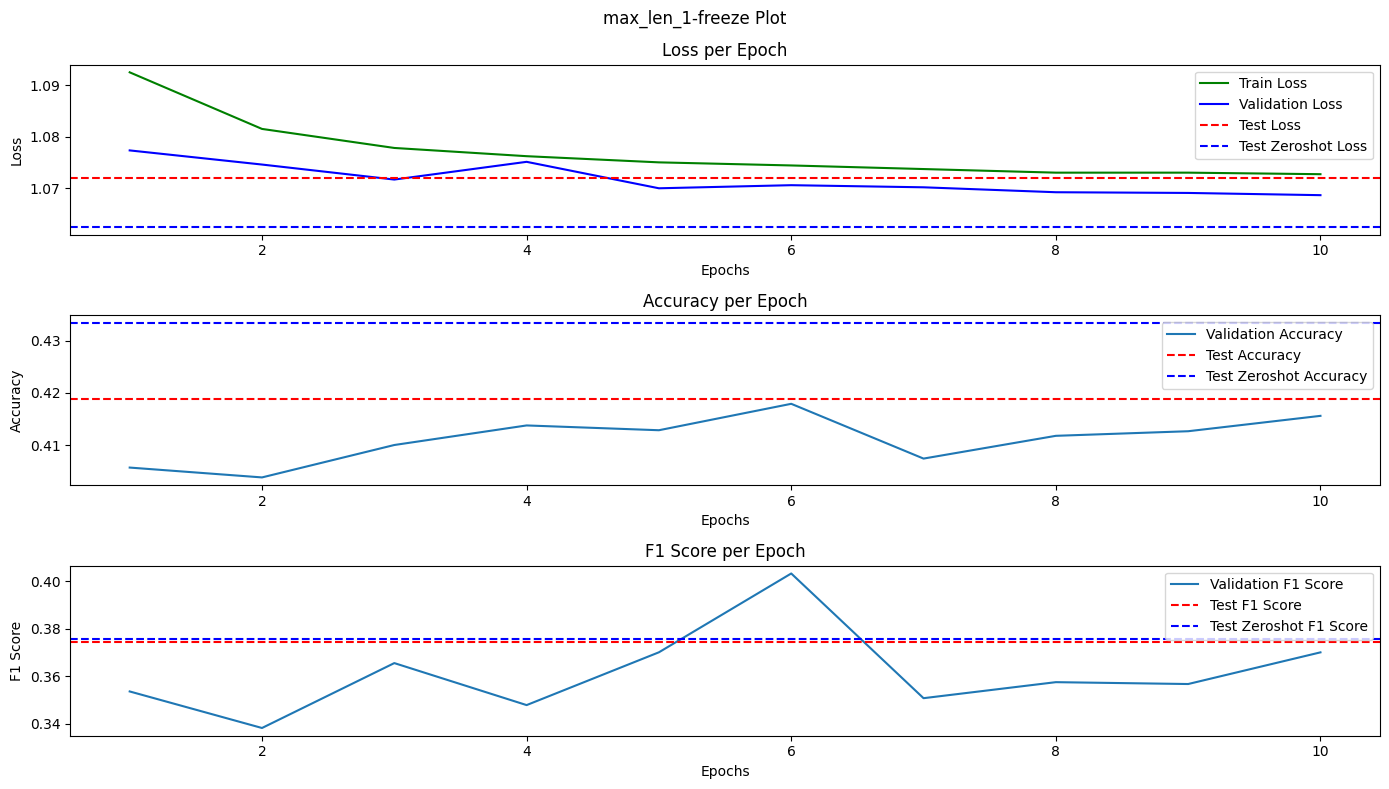

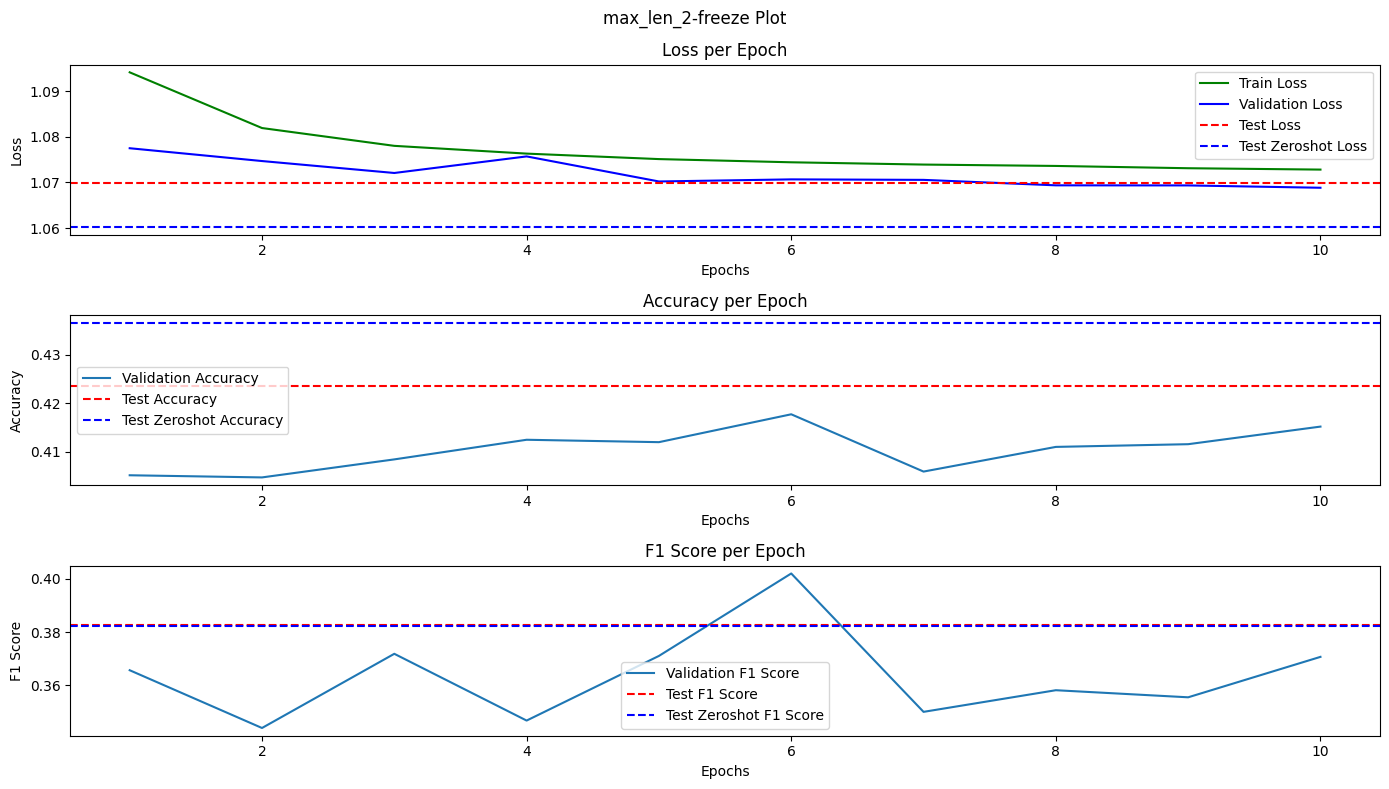

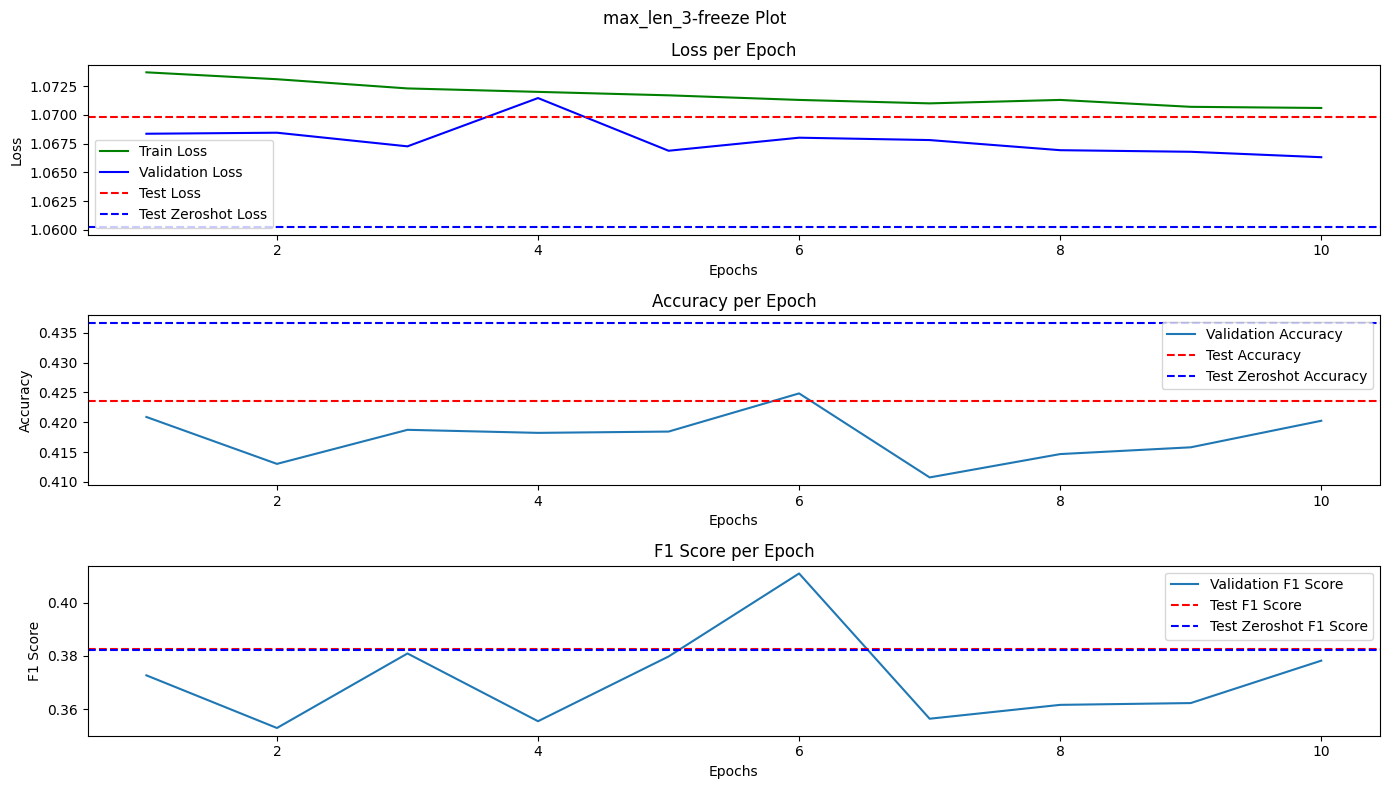

In [ ]:
import matplotlib.pyplot as plt

def plotting(max_len_type):
    # 로그 데이터 추출
    log_history = trainer_dict[max_len_type].state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_f1 = []

    # 로그 데이터 분리
    for log in log_history:
        if 'epoch' in log:
            current_epoch = log['epoch']
            if current_epoch not in epochs:
                epochs.append(current_epoch)
            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                val_loss.append(log['eval_loss'])
            if 'eval_accuracy' in log:
                val_accuracy.append(log['eval_accuracy'])
            if 'eval_f1' in log:
                val_f1.append(log['eval_f1'])

    test_loss = metrics_dict[max_len_type]['test']['test_loss']
    test_accuracy = metrics_dict[max_len_type]['test']['test_accuracy']
    test_f1 = metrics_dict[max_len_type]['test']['test_f1']

    test_loss_zeroshot = metrics_dict[max_len_type]['test_data_zeroshot']['test_loss']
    test_accuracy_zeroshot = metrics_dict[max_len_type]['test_data_zeroshot']['test_accuracy']
    test_f1_zeroshot = metrics_dict[max_len_type]['test_data_zeroshot']['test_f1']

    # 플로팅
    plt.figure(figsize=(14, 8))

    # 손실 플롯
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss, color = 'g', label='Train Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.axhline(y=test_loss_zeroshot, color='blue', linestyle='--', label='Test Zeroshot Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # 정확도 및 F1 스코어 플롯
    plt.subplot(3, 1, 2)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.axhline(y=test_accuracy_zeroshot, color='blue', linestyle='--', label='Test Zeroshot Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
    plt.axhline(y=test_f1_zeroshot, color='blue', linestyle='--', label='Test Zeroshot F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.legend()

    plt.suptitle(f"{max_len_type} Plot")
    plt.tight_layout()
    print("\n\n")

plotting('max_len_1-freeze')
plotting('max_len_2-freeze')
plotting('max_len_3-freeze')
plt.show()

In [ ]:
import pandas as pd

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 학습 가능한 파라미터 수 출력
trainable_params_lst = [count_trainable_parameters(model_dict[name]) for name in metrics_dict.keys()]
train_runtime_lst = [trainer_dict[name].state.log_history[-1]['train_runtime'] for name in  metrics_dict.keys()]

result_df = pd.DataFrame([metrics_dict[name]['test'] for name in  metrics_dict.keys()])
result_df.index = metrics_dict.keys()
result_df['trainable_parameters']  = trainable_params_lst
result_df['train_runtime'] = train_runtime_lst
display(result_df[['test_loss','test_accuracy','test_f1','trainable_parameters', 'train_runtime', 'test_runtime']])

result_df_zeroshot = pd.DataFrame([metrics_dict[name]['test_data_zeroshot'] for name in  metrics_dict.keys()])
result_df_zeroshot.index = metrics_dict.keys()
result_df_zeroshot['trainable_parameters']  = trainable_params_lst
result_df_zeroshot['train_runtime'] = train_runtime_lst
result_df_zeroshot = result_df_zeroshot.rename(columns = {'test_loss':'test_zeroshot_loss', 'test_accuracy':'test_zeroshot_accuracy','test_f1':'test_zeroshot_f1'})
display(result_df_zeroshot[['test_zeroshot_loss','test_zeroshot_accuracy','test_zeroshot_f1','trainable_parameters', 'train_runtime', 'test_runtime']])

,test_loss,test_accuracy,test_f1,trainable_parameters,train_runtime,test_runtime
max_len_1-freeze,1.071868,0.418747,0.374395,3076,10564.0155,25.3585
max_len_2-freeze,1.069830,0.423637,0.382458,3076,15165.2014,36.7184
max_len_3-freeze,1.069830,0.423637,0.382458,3076,15146.4501,49.7128


,test_zeroshot_loss,test_zeroshot_accuracy,test_zeroshot_f1,trainable_parameters,train_runtime,test_runtime
max_len_1-freeze,1.062468,0.433381,0.375894,3076,10564.0155,25.4177
max_len_2-freeze,1.060264,0.436635,0.382118,3076,15165.2014,36.6289
max_len_3-freeze,1.060264,0.436635,0.382118,3076,15146.4501,49.7998


## 5. [My Code] Conclusion